In [160]:
import networkx as nx
import matplotlib.pyplot as plt 
from IPython.display import SVG, display
import pygraphviz
# Note: to install pygraphviz on macOS, you need to first install graphviz using homebrew,
# and then tell pip to look for the graphviz headers and libraries in the homebrew directory:
#  brew install graphviz
#  python3 -m pip install \
#                --config-settings="--global-option=build_ext" \
#                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#                pygraphviz

# TODO: move the SVG rendering to a git pre-commit hook so that people can change DOT files directly without needing
# to run this script to see the changes.

# README

## Figure 1

In [171]:
class BlockGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.graph.add_node('source', label='start')
        self.graph.add_node('sink', label='end')
        self.source_node = 'source'
        self.sink_node = 'sink'

    def add_node(self, sequence, node_id=None):
        """
        Adds a node to the graph.

        Parameters:
        sequence (str): The sequence associated with a node. Note that in the actual gen code the sequence is hashed to save space.
        """
        if node_id is None:
            # Start node IDs at 1, not counting source and sink
            node_id = self.graph.number_of_nodes() - 1 

        self.graph.add_node(node_id, sequence=sequence)
        return node_id
    
    def connect_to_source(self, node_id, to_pos=0):
        """
        Connects a node to the source node.

        Parameters:
        node_id (int): The ID of the node to connect to the source.
        to_pos (int): The position at which the edge arrives at node.
        """
        self.graph.add_edge(self.source_node, node_id, to_pos=to_pos, rank='same', constraint=False)

    def connect_to_sink(self, node_id, from_pos=-1):
        """
        Connects a node to the sink node.

        Parameters:
        node_id (int): The ID of the node to connect to the sink.
        from_pos (int): The position from which the edge departs from the node.
        """
        if from_pos == -1:
            from_pos = len(self.graph.nodes[node_id]['sequence'])-1

        self.graph.add_edge(node_id, self.sink_node, from_pos=from_pos, rank='same', constraint=False)

    def add_edge(self, source, target):
        """
        Adds an edge to the graph with port information stored as edge attributes.

        Parameters:
        source (tuple): A tuple containing the source node and the position from which the edge departs.
        target (tuple): A tuple containing the target node and the position at which the edge arrives.
        """
        self.graph.add_edge(source[0], target[0], from_pos=source[1], to_pos=target[1])

    def import_from_db(self, db):
        """
        Imports a graph from a gen database.

        Parameters:
        db (Database): The gen sqlite3 .db file to import the graph from.
        """
        con = sqlite3.connect(db_file)
        cur = con.cursor()
        cur.execute('''SELECT id, sequence
        FROM nodes
        JOIN sequences
        ON nodes.sequence_hash = sequences.hash 
        ''')
        nodes = cur.fetchall()

        source_node, sink_node = None, None
        for id, sequence in nodes:
            if sequence.startswith('start-'):
                source_node = id
                continue
            if sequence.startswith('end-'):
                sink_node = id
                continue

            self.add_node(sequence, node_id=id)


        cur.execute('SELECT id, source_node_id, source_coordinate, target_node_id, target_coordinate from edges')
        edges = cur.fetchall()

        # In the Rust code, from_pos is considered to be exclusive to the range of the block, 
        # so we need to subtract 1 to get the conventional position in the sequence.
        for id, source, from_pos, target, to_pos in edges:
            if source == source_node:
                self.connect_to_source(target, to_pos)
            elif target == sink_node:
                self.connect_to_sink(source, from_pos-1)
            else:
                self.add_edge((source, from_pos-1), (target, to_pos))
        
        

    def highlight_ranges(self, node_id, highlight_ranges):
        """
        Highlights specific ranges in a node's sequence.

        Parameters:
        node_id (int): The ID of the node to apply highlights to.
        highlight_ranges (list): A list of tuples containing the start and end positions of the ranges to highlight.
        """
        sequence = self.graph.nodes[node_id]['sequence']
        highlights = [False] * len(sequence)
        for start, end in highlight_ranges:
            for i in range(start, end):
                highlights[i] = True
        self.graph.nodes[node_id]['highlights'] = highlights

    def render_graph(self, filename=None, rankdir='TD', minimize=False):
        # Create a copy of the graph to avoid modifying the original
        graph = self.graph.copy()

        for node in graph.nodes:
            if node in ['source', 'sink']:
                continue
            sequence = graph.nodes[node]['sequence']
            highlights = graph.nodes[node].get('highlights', [False] * len(sequence))
            formatted_sequence = [f'<B>{c}</B>' if highlights[i] else c for i, c in enumerate(sequence)]

            if minimize:
                # Only show the ports that are connected to other nodes
                connected_ports = set()
                for edge in graph.in_edges(node):
                    connected_ports.add(graph.edges[edge]['to_pos'])
                    print(f"in: {graph.edges[edge]['to_pos']}")
                for edge in graph.out_edges(node):
                    print(f"out: {graph.edges[edge]['from_pos']}")
                    connected_ports.add(graph.edges[edge]['from_pos'])
                connected_ports = sorted(connected_ports)
                # Start of a list that contains each port of the node, with ellipses between ports that are not sequential
                labeled_sequence = [f"<TD PORT='{connected_ports[0]}'><FONT FACE='Courier New'>{formatted_sequence[connected_ports[0]]}<SUB>{connected_ports[0]}</SUB></FONT></TD>"]
                if len(connected_ports) > 1 and (connected_ports[1]-connected_ports[0]) > 1:
                    labeled_sequence.append("<TD>...</TD>")
                # Loop over the connected ports in pairs of two, so that we can take into account the gaps between them.
                for a, b in zip(connected_ports, connected_ports[1:]):
                    labeled_sequence.append(f"<TD PORT='{b}'><FONT FACE='Courier New'>{formatted_sequence[b]}<SUB>{b}</SUB></FONT></TD>")
                    if b - a > 1 and b != connected_ports[-1]:
                        labeled_sequence.append("<TD>...</TD>")
            else:
                labeled_sequence = [f"<TD PORT='{i}'><FONT FACE='Courier New'>{c}</FONT></TD>" 
                                      for i, c in enumerate(formatted_sequence)]

            label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
            label += f"<TD BORDER='0' PORT='caption'>{node}: </TD>"
            label += '\n'.join(labeled_sequence)
            label += "</TR></TABLE>>"

            graph.nodes[node]['shape'] = 'none'
            graph.nodes[node]['margin'] = 0
            graph.nodes[node]['label'] = label


        for edge in graph.edges:
            # Connect the head and tail of each edge to the correct port
            graph.edges[edge]['headport'] = f"{graph.edges[edge].get('to_pos','w')}"
            graph.edges[edge]['tailport'] = f"{graph.edges[edge].get('from_pos','e')}"
            # Cleaner look for the first edge coming out of the source node:
            if edge[0] == 'source' and graph.edges[edge]['headport'] == '0':
                graph.edges[edge]['headport'] = 'caption'
            # If the full graph is layed out from left to right, do the same for all nodes:
            if rankdir == 'LR' and graph.edges[edge]['headport'] == '0':
                graph.edges[edge]['headport'] = 'caption'

        # Convert the networkx graph to a pygraphviz graph
        graph = nx.nx_agraph.to_agraph(graph)

        # Draw the graph using pygraphviz
        graph.layout(prog='dot', args=f'-Grankdir={rankdir} -Gsplines=true -Goverlap=scale')
        if filename:
            graph.write(f'{filename}.dot')
            graph.draw(f'{filename}.svg', prog='dot', format='svg')
            
        display(SVG(graph.draw(prog='dot', format='svg')))


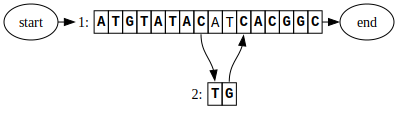

In [172]:
G = BlockGraph()

n1 = G.add_node('ATGTATACATCACGGC') # Derived from BBa_K1896001
n2 = G.add_node('TG')
G.connect_to_source(n1)
G.connect_to_sink(n1)
G.add_edge((n1, 7), (n2, 0))
G.add_edge((n2, 1), (n1, 10))
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n2, [(0, 2)])

G.render_graph('figure_1', minimize=False)

in: 0
in: 657
in: 657
in: 657
out: 1048
out: -1
out: -1
out: -1
in: 0
out: 63
out: 63
out: 63
in: 0
in: 0
in: 0
out: 57
out: 57
out: 57
in: 0
in: 0
in: 0
out: 43
out: 43
out: 43
in: 0
in: 0
in: 0
out: 49
out: 49
out: 49
in: 0
in: 0
in: 0
out: 51
out: 51
out: 51
in: 0
in: 0
in: 0
out: 59
out: 59
out: 59
in: 0
in: 0
in: 0
out: 75
out: 75
out: 75
in: 0
in: 0
in: 0
out: 644
in: 0
out: 64
out: 64
out: 64
in: 0
in: 0
in: 0
out: 57
out: 57
out: 57
in: 0
in: 0
in: 0
out: 43
out: 43
out: 43
in: 0
in: 0
in: 0
out: 49
out: 49
out: 49
in: 0
in: 0
in: 0
out: 52
out: 52
out: 52
in: 0
in: 0
in: 0
out: 59
out: 59
out: 59
in: 0
in: 0
in: 0
out: 75
out: 75
out: 75
in: 0
in: 0
in: 0
out: 647
in: 0
out: 64
out: 64
out: 64
in: 0
in: 0
in: 0
out: 57
out: 57
out: 57
in: 0
in: 0
in: 0
out: 43
out: 43
out: 43
in: 0
in: 0
in: 0
out: 49
out: 49
out: 49
in: 0
in: 0
in: 0
out: 52
out: 52
out: 52
in: 0
in: 0
in: 0
out: 59
out: 59
out: 59
in: 0
in: 0
in: 0
out: 75
out: 75
out: 75
in: 0
in: 0
in: 0
out: 654


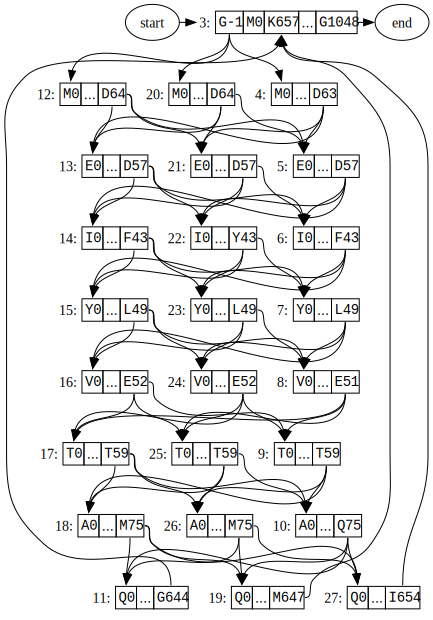

In [ ]:
import sqlite3

db_file = '../../examples/protein_engineering/test.db'

G = BlockGraph()
G.import_from_db(db_file)
G.render_graph('test',rankdir='LR', minimize=True)



In [153]:
for node in G.graph.nodes:
    print(f"{node}:{len(G.graph.nodes[node].get('sequence', ''))}")

source:0
sink:0
3:1049
4:64
5:58
6:44
7:50
8:52
9:60
10:76
11:645
12:65
13:58
14:44
15:50
16:53
17:60
18:76
19:648
20:65
21:58
22:44
23:50
24:53
25:60
26:76
27:655


In [ ]:
G.graph.edges(data=True)


OutEdgeDataView([('source', 3, {'to_pos': 0, 'rank': 'same', 'constraint': False}), (3, 'sink', {'from_pos': 1049, 'rank': 'same', 'constraint': False}), (3, 12, {'from_pos': 0, 'to_pos': 0}), (3, 20, {'from_pos': 0, 'to_pos': 0}), (3, 4, {'from_pos': 0, 'to_pos': 0}), (4, 21, {'from_pos': 64, 'to_pos': 0}), (4, 5, {'from_pos': 64, 'to_pos': 0}), (4, 13, {'from_pos': 64, 'to_pos': 0}), (5, 6, {'from_pos': 58, 'to_pos': 0}), (5, 22, {'from_pos': 58, 'to_pos': 0}), (5, 14, {'from_pos': 58, 'to_pos': 0}), (6, 15, {'from_pos': 44, 'to_pos': 0}), (6, 23, {'from_pos': 44, 'to_pos': 0}), (6, 7, {'from_pos': 44, 'to_pos': 0}), (7, 24, {'from_pos': 50, 'to_pos': 0}), (7, 8, {'from_pos': 50, 'to_pos': 0}), (7, 16, {'from_pos': 50, 'to_pos': 0}), (8, 9, {'from_pos': 52, 'to_pos': 0}), (8, 17, {'from_pos': 52, 'to_pos': 0}), (8, 25, {'from_pos': 52, 'to_pos': 0}), (9, 26, {'from_pos': 60, 'to_pos': 0}), (9, 10, {'from_pos': 60, 'to_pos': 0}), (9, 18, {'from_pos': 60, 'to_pos': 0}), (10, 19, {'from

In [117]:
foo = nx.nx_agraph.to_agraph(G.graph)

foo.get_edge('9','18').attr['to_pos']

'0'

In [107]:
dir(foo)

['__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_close_handle',
 '_draw',
 '_get_fh',
 '_get_prog',
 '_layout',
 '_manually_parse_args',
 '_owns_handle',
 '_prepare_nbunch',
 '_repr_mimebundle_',
 '_run_prog',
 '_svg_repr',
 '_update_handle_references',
 '_which',
 'acyclic',
 'add_cycle',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_path',
 'add_subgraph',
 'clear',
 'close',
 'copy',
 'degree',
 'degree_iter',
 'delete_edge',
 'delete_edges_from',
 'delete_node',
 'delete_nodes_from',
 'delete_subgraph',
 'directed',
 'draw',
 'e

In [104]:
foo

<AGraph <Swig Object of type 'Agraph_t *' at 0x123845740>>

In [6]:
!pwd

/Users/bvh/Git/gen/docs/figures


## Figure 2

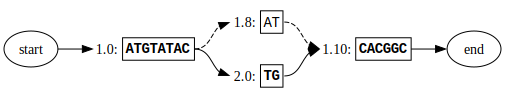

In [4]:
G = nx.DiGraph()
G.add_node('start')
G.add_node('end')
G.add_node('1.0', sequence='ATGTATAC', highlight=True)
G.add_node('1.8', sequence='AT')
G.add_node('2.0', sequence='TG', highlight=True)
G.add_node('1.10', sequence='CACGGC', highlight=True)

G.add_edge('start', '1.0')
G.add_edge('1.0', '1.8', style='dashed')
G.add_edge('1.0', '2.0')
G.add_edge('1.8', '1.10', style='dashed')
G.add_edge('2.0', '1.10')
G.add_edge('1.10', 'end')

for node in G.nodes:
    if node in ['start', 'end']:
        continue

    G.nodes[node]['shape'] = 'none'
    G.nodes[node]['margin'] = 0

    seq = G.nodes[node]['sequence']
    label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
    label += f"<TD BORDER='0' PORT='caption'>{node}: </TD>"
    if G.nodes[node].get('highlight', False):
        label += f"<TD><FONT FACE='Courier New'><B>{seq}</B></FONT></TD>"
    else:
        label += f"<TD><FONT FACE='Courier New'>{seq}</FONT></TD>"
    label += "</TR></TABLE>>"
    G.nodes[node]['label'] = label

for edge in G.edges:
    G.edges[edge]['headport'] = G.edges[edge].get('headport','w')
    G.edges[edge]['tailport'] = G.edges[edge].get('tailport','e')

# Convert the networkx graph to a pygraphviz graph
G = nx.nx_agraph.to_agraph(G)

# Draw the graph using pygraphviz
G.layout(prog='dot', args='-Grankdir=LR -Gsplines=true -Goverlap=scale')
G.write('figure_2.dot')
G.draw('figure_2.svg', prog='dot', format='svg')
    
display(SVG(G.draw(prog='dot', format='svg')))

